# AGH Modelling of Physical Systems Lab 04 - assignment
Michał Szczygieł

## Advection-Diffusion Equation  

The advection-diffusion equation models the transport of a scalar quantity, such as temperature, pollutant concentration, or chemical substances, under the influence of both advection (bulk flow of the medium) and diffusion (spreading due to molecular motion). It is expressed as:  

$$\frac{\partial C}{\partial t}+u\frac{\partial C}{\partial x}-D\frac{\partial^2C}{\partial x^2}=0$$

where: 

- $\psi(x,t)$ represents the concentration at position $x$ and time $t$,  
- $u$ is the advection velocity,  
- $D$ is the diffusion coefficient.  

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from open_atmos_jupyter_utils import show_plot

### Analytical solution

The analytical solution of the above equation is:
$$C(x,t) = e^{-(\frac{u^2}{4D} + \pi^2D)t}sin(\pi x)$$

where:
- $D$ and $u$ are constants,
- $0 \leq x \leq 1$,
- $t \geq 0$,
- $C(0,t) = C(1,t) = 0$,
- $C(x, 0) = sin(\pi x)$.

In [5]:
class AnalyticalSolution:
  def __init__(self, u, D):
    self.u = u
    self.D = D

  def __call__(self, x, t):
    return np.exp(-(self.u**2 / (4 * self.D) + np.pi**2 * self.D) * t) * np.sin(np.pi * x)

### Numerical solution

To numerically solve this equation, one can employ the upwind scheme commonly used for the pure advection equation. Originally designed for

$$\frac{\partial C}{\partial t} = -u \frac{\partial C}{\partial x},$$

the upwind method can be adapted by substituting the advection speed $u$ with an effective velocity that accounts for both advection and diffusion. In this context, the effective velocity becomes

$$u_{\text{eff}} = u - D \frac{\partial_x C}{C} C,$$

which essentially combines the contributions from both processes. This leads to a situation where the overall Courant number is the sum of the Courant numbers associated with the individual advection and diffusion components.

In [6]:
def F(psi_l, psi_r, C):
    return .5 * (C + abs(C)) * psi_l + \
           .5 * (C - abs(C)) * psi_r

class shift:
    def __init__(self, *, add, sub):
        self.add = add
        self.sub = sub

    def __radd__(self, o):
        return slice(o.start + self.add, o.stop + self.add)

    def __rsub__(self, o):
        return slice(o.start - self.sub, o.stop - self.sub)

one = shift(add=1, sub=1)
hlf = shift(add=0, sub=1)

class NumericalSolution:
    def __init__(self, *, t_max, u, D, nt, dx, nx):
        self.u = u
        self.D = D

        self.nt = nt
        self.dt = t_max/nt

        self.dx = dx
        self.i = slice(1, nx-2)
        self.im = slice(1, nx-1)

        self.analytical = AnalyticalSolution(u=self.u, D=self.D)
    
    def __call__(self, x):
        psi = self.analytical(x, 0)
        C = np.zeros(len(psi) - 1)

        for j in range(self.nt):
            C[self.im - hlf] = self.dt / self.dx * (self.u - self.D * 2 / self.dx * (psi[self.im] - psi[self.im-one]) / (psi[self.im] + psi[self.im-one]))
            assert max(abs(C)) <= 1 
            psi[self.i] = psi[self.i] - (F(psi[self.i], psi[self.i+one], C[self.i+hlf]) - F(psi[self.i-one], psi[self.i], C[self.i-hlf]))

        return psi

In [7]:
u = 3.6e-4
D = 3.6e-3
t_max = 10
nx = 64
x, dx = np.linspace(0, 1, nx, endpoint=True, retstep=True)

analytical = AnalyticalSolution(u=u, D=D)
numerical = NumericalSolution(t_max=t_max, u=D, D=D, nt=500, dx=dx, nx=nx)

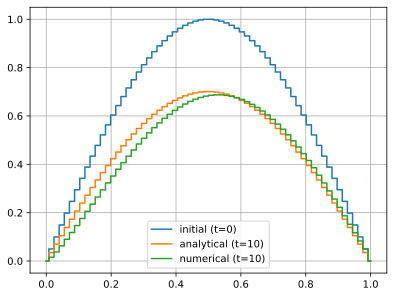

In [8]:
fig = plt.figure()
plt.step(x, analytical(x=x, t=0), label='initial (t=0)', where='mid')
plt.step(x, analytical(x=x, t=t_max), label=f'analytical (t={t_max})', where='mid')
plt.step(x, numerical(x), label=f'numerical (t={t_max})', where='mid')
plt.legend()
plt.grid()

show_plot('numeric.pdf', fig=fig)

In [9]:
def rmse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Computes the Root Mean Squared Error (RMSE) between true and predicted values.

    Args:
        y_true (np.ndarray): Array of true values.
        y_pred (np.ndarray): Array of predicted values.

    Returns:
        float: RMSE value.
    """
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [10]:
print('RMSE:', rmse(analytical(x=x, t=t_max), numerical(x)))

RMSE: 0.03954746694298708


## Conclusion

The numerical solution provides a reasonable approximation, but it shows a noticeable difference compared to the analytical solution. However, an RMSE of $0.04$ is relatively low, considering the maximum value of this equation is above $0.6$.